In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
import scipy as sp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras import layers

### In this notebook, we use a compressed version of JLA compilation
#### First, we need to read the data. In this case, we use the covariance matrix of systematic errors 

In [2]:
syscov = np.loadtxt('/home/isidro/Documents/gitHub/misRepos/neuralCosmoReconstruction/data/cov_jla_binned_distances_31nodes_v1.txt',skiprows=1).reshape((31,31))
# syscov = np.loadtxt('data/jla_v0_covmatrix.dat',skiprows=1).reshape((740,740))

### Verify that there ar not complex numbers and that the matrix is symmetrical

In [3]:
count = 0

for i in range(len(syscov)):
    for j in range(len(syscov)):
        if np.iscomplex(syscov[i,j]):
            print("COMPLEX")
        if syscov[i,j] != syscov[j,i]:
#             print(i,j)
#             print(syscov[i,j], syscov[j,i]) 
            count+=1
            syscov[j,i] = syscov[i, j]

count

0

### Visualization of the covariance matrix:

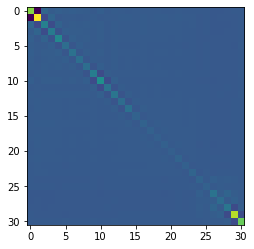

In [4]:
plt.imshow(syscov)


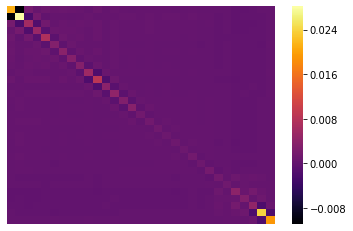

In [5]:
sns.heatmap(pd.DataFrame(syscov), annot=False, fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno')
plt.savefig("original_cov_binned_JLA.png", dpi=200)

In [6]:
np.min(syscov), np.max(syscov) #checking non-negatives in the diagonal

(-0.01084098704, 0.02815552265)

### Generate a data set with covariance matrix from the original plus gaussian noise

In [111]:
numMatrix = 1000
noise_factor1 = 1e-5
noise_factor2 = 1
covset = np.zeros((numMatrix, 31, 31))
covset_noise = np.zeros((numMatrix, 31, 31))

for i in range(numMatrix): 
    print("\r Generating {} matrix".format(i+1), end=" ")
    err = np.random.normal(loc=0.0, scale=0.01, size=syscov.shape) 
    covset[i] = syscov  + noise_factor1 * err
    covset_noise[i] = syscov  + noise_factor2 * err
#     fig = plt.figure(figsize=(6,6))
#     sns.heatmap(pd.DataFrame(pset[i]*maxval), 
#             fmt='g', xticklabels=False, yticklabels=False, 
#             cmap = 'inferno', cbar=False,
#             robust=False)
#     fig.savefig('image/covMatrix_{}.png'.format(i), dpi=300, )
#     plt.clf()

 Generating 1000 matrix 

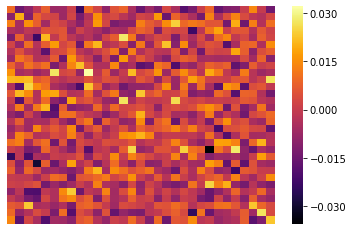

In [112]:
sns.heatmap(pd.DataFrame(covset_noise[1]), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)

In [113]:
print(np.shape(covset))

(1000, 31, 31)


(1000, 31, 31)


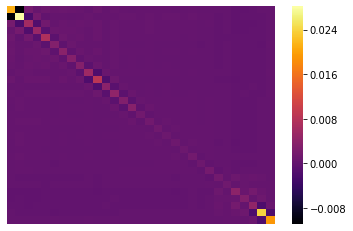

In [114]:
print(np.shape(covset))
split = 0.8
ntrain = int(split * numMatrix)
indx = [ntrain]
covset_train, covset_test = np.split(covset, indx, axis=0)
covset_noise_train, covset_noise_test = np.split(covset_noise, indx, axis=0)

sns.heatmap(pd.DataFrame(covset_test[0]), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)
covset_train = covset_train.reshape((len(covset_train), np.prod(covset_train.shape[1:])))
covset_test = covset_test.reshape((len(covset_test), np.prod(covset_test.shape[1:])))
covset_noise_train = covset_noise_train.reshape((len(covset_noise_train), np.prod(covset_noise_train.shape[1:])))
covset_noise_test = covset_noise_test.reshape((len(covset_noise_test), np.prod(covset_noise_test.shape[1:])))


In [115]:
# input_cov = Input(shape=(31, 31, 1))

# This is the size of our encoded representations
encoding_dim = 31  

# This is our input image
input_img = tf.keras.Input(shape=(31*31,))
# begin encoder
x = layers.Dense(300, activation='tanh')(input_img)
x = layers.Dense(200, activation='tanh')(x)
encoded = layers.Dense(encoding_dim, activation='tanh')(x)

#begin decoder
x = layers.Dense(200, activation='tanh')(encoded)
x = layers.Dense(300, activation='tanh')(x)
decoded = layers.Dense(31*31, activation='linear')(x)

# This model maps an input to its reconstruction
autoencoder = tf.keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()

Model: "functional_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 961)]             0         
_________________________________________________________________
dense_30 (Dense)             (None, 300)               288600    
_________________________________________________________________
dense_31 (Dense)             (None, 200)               60200     
_________________________________________________________________
dense_32 (Dense)             (None, 31)                6231      
_________________________________________________________________
dense_33 (Dense)             (None, 200)               6400      
_________________________________________________________________
dense_34 (Dense)             (None, 300)               60300     
_________________________________________________________________
dense_35 (Dense)             (None, 961)             

In [116]:
encoder = tf.keras.Model(input_img, encoded)
# This is our encoded (32-dimensional) input
encoded_input = tf.keras.Input(shape=(encoding_dim,))

decoder_layer1 = autoencoder.layers[-3]
decoder_layer2 = autoencoder.layers[-2]
decoder_layer3 = autoencoder.layers[-1]

# create the decoder model
decoder = Model(encoded_input, 
                decoder_layer3(decoder_layer2(decoder_layer1(encoded_input))))

In [117]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0,
                                   patience=10, 
                                   restore_best_weights=True)]

autoencoder_train = autoencoder.fit(covset_noise_train, covset_train,
                epochs=300,
                batch_size=16,
                shuffle=True,
                validation_data=(covset_noise_test, covset_test),
                callbacks=callbacks)
#                 callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/300
50/50 [==============================] - 0s 5ms/step - loss: 2.1871e-05 - val_loss: 1.0531e-05
Epoch 2/300
50/50 [==============================] - 0s 3ms/step - loss: 5.6263e-06 - val_loss: 5.3343e-06
Epoch 3/300
50/50 [==============================] - 0s 3ms/step - loss: 2.7679e-06 - val_loss: 3.5049e-06
Epoch 4/300
50/50 [==============================] - 0s 3ms/step - loss: 1.6659e-06 - val_loss: 2.5023e-06
Epoch 5/300
50/50 [==============================] - 0s 3ms/step - loss: 1.1337e-06 - val_loss: 1.9298e-06
Epoch 6/300
50/50 [==============================] - 0s 3ms/step - loss: 8.3158e-07 - val_loss: 1.5604e-06
Epoch 7/300
50/50 [==============================] - 0s 3ms/step - loss: 6.3579e-07 - val_loss: 1.3038e-06
Epoch 8/300
50/50 [==============================] - 0s 3ms/step - loss: 5.0137e-07 - val_loss: 1.1104e-06
Epoch 9/300
50/50 [==============================] - 0s 3ms/step - loss: 4.0422e-07 - val_loss: 9.8270e-07
Epoch 10/300
50/50 [=================

Epoch 77/300
50/50 [==============================] - 0s 3ms/step - loss: 1.4228e-08 - val_loss: 8.7818e-08
Epoch 78/300
50/50 [==============================] - 0s 3ms/step - loss: 1.4223e-08 - val_loss: 8.8343e-08
Epoch 79/300
50/50 [==============================] - 0s 3ms/step - loss: 1.3964e-08 - val_loss: 8.5910e-08
Epoch 80/300
50/50 [==============================] - 0s 3ms/step - loss: 1.4448e-08 - val_loss: 8.5722e-08
Epoch 81/300
50/50 [==============================] - 0s 3ms/step - loss: 1.3893e-08 - val_loss: 8.4839e-08
Epoch 82/300
50/50 [==============================] - 0s 3ms/step - loss: 1.3777e-08 - val_loss: 8.2211e-08
Epoch 83/300
50/50 [==============================] - 0s 3ms/step - loss: 1.3522e-08 - val_loss: 8.2275e-08
Epoch 84/300
50/50 [==============================] - 0s 3ms/step - loss: 1.3941e-08 - val_loss: 8.1823e-08
Epoch 85/300
50/50 [==============================] - 0s 3ms/step - loss: 1.3459e-08 - val_loss: 7.9332e-08
Epoch 86/300
50/50 [========

50/50 [==============================] - 0s 3ms/step - loss: 9.8189e-09 - val_loss: 4.7208e-08
Epoch 153/300
50/50 [==============================] - 0s 3ms/step - loss: 7.7659e-09 - val_loss: 4.7511e-08
Epoch 154/300
50/50 [==============================] - 0s 3ms/step - loss: 1.0083e-08 - val_loss: 4.8728e-08
Epoch 155/300
50/50 [==============================] - 0s 3ms/step - loss: 7.6250e-09 - val_loss: 4.4902e-08
Epoch 156/300
50/50 [==============================] - 0s 3ms/step - loss: 7.5830e-09 - val_loss: 4.6035e-08
Epoch 157/300
50/50 [==============================] - 0s 3ms/step - loss: 8.9413e-09 - val_loss: 4.5563e-08
Epoch 158/300
50/50 [==============================] - 0s 3ms/step - loss: 7.3525e-09 - val_loss: 4.6800e-08
Epoch 159/300
50/50 [==============================] - 0s 3ms/step - loss: 8.4903e-09 - val_loss: 4.5056e-08
Epoch 160/300
50/50 [==============================] - 0s 3ms/step - loss: 7.7016e-09 - val_loss: 4.4831e-08
Epoch 161/300
50/50 [============

50/50 [==============================] - 0s 3ms/step - loss: 6.1382e-09 - val_loss: 3.2062e-08
Epoch 228/300
50/50 [==============================] - 0s 3ms/step - loss: 6.5888e-09 - val_loss: 3.6402e-08
Epoch 229/300
50/50 [==============================] - 0s 3ms/step - loss: 5.3938e-09 - val_loss: 3.3467e-08
Epoch 230/300
50/50 [==============================] - 0s 3ms/step - loss: 5.8978e-09 - val_loss: 3.5027e-08
Epoch 231/300
50/50 [==============================] - 0s 3ms/step - loss: 6.1898e-09 - val_loss: 3.3567e-08
Epoch 232/300
50/50 [==============================] - 0s 3ms/step - loss: 5.7347e-09 - val_loss: 3.1392e-08
Epoch 233/300
50/50 [==============================] - 0s 3ms/step - loss: 6.2392e-09 - val_loss: 3.2890e-08
Epoch 234/300
50/50 [==============================] - 0s 3ms/step - loss: 5.5568e-09 - val_loss: 3.3167e-08
Epoch 235/300
50/50 [==============================] - 0s 3ms/step - loss: 7.0980e-09 - val_loss: 3.5333e-08
Epoch 236/300
50/50 [============

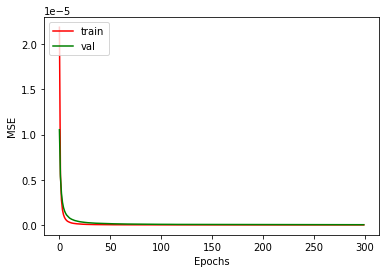

In [118]:
plt.plot(autoencoder_train.history['loss'], color='r', )
plt.plot(autoencoder_train.history['val_loss'], color='g')
# plt.title('model loss function')
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('loss_binned_JLA.png', dpi=200)

In [119]:
unet = np.sqrt(np.min(autoencoder_train.history['val_loss']))
print(unet**2, np.min(autoencoder_train.history['loss']))

2.554910061292048e-08 3.794437652970828e-09


In [120]:
encoded_imgs = encoder.predict(covset_test)
decoded_imgs = decoder.predict(encoded_imgs)
print(np.shape(encoded_imgs))
df = pd.DataFrame(encoded_imgs)
np.min(encoded_imgs)

(200, 31)


-0.0005298706

(200, 961)


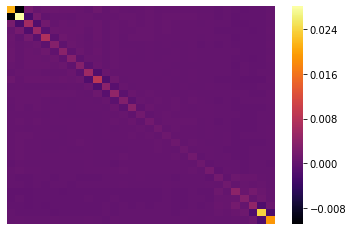

In [121]:
print(np.shape(decoded_imgs))

sns.heatmap(pd.DataFrame(decoded_imgs[0].reshape(31,31)), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)
# plt.savefig("decoded_img22.png")

In [122]:
print(np.shape(decoded_imgs))

(200, 961)


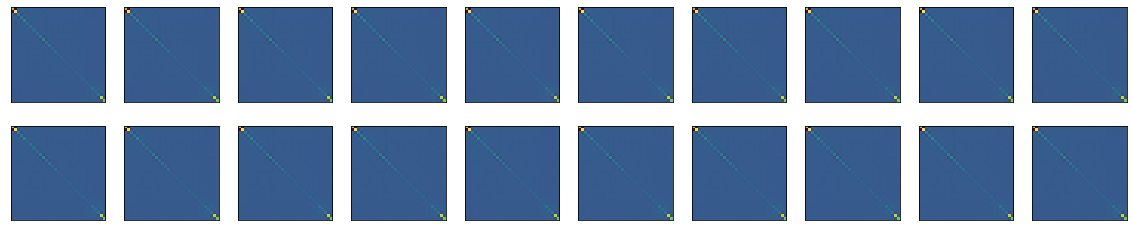

In [123]:
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(covset_test[i].reshape(31, 31))
#     plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(31, 31))
#     plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

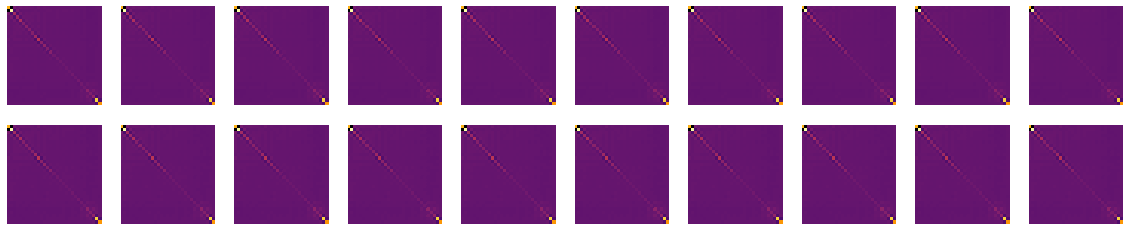

In [124]:
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    sns.heatmap(covset_test[i].reshape(31, 31), cbar=False, fmt='g', xticklabels=False, yticklabels=False, 
                cmap = 'inferno')
    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    sns.heatmap(decoded_imgs[i].reshape(31, 31), cbar=False, fmt='g', xticklabels=False, yticklabels=False, 
                cmap = 'inferno')
plt.savefig('predicted_covs_binned_jla.png', dpi=200)

### Now we train another neural network for z and $D_L(z)$

           z      $D_L$
0   0.010000  32.953887
1   0.011762  33.879003
2   0.013833  33.842141
3   0.016270  34.118567
4   0.019136  34.593446
5   0.022507  34.939027
6   0.026472  35.252096
7   0.031135  35.748502
8   0.036620  36.069788
9   0.043071  36.434570
10  0.050658  36.651111
11  0.059582  37.158014
12  0.070077  37.430173
13  0.082422  37.956616
14  0.096941  38.253254
15  0.114018  38.612869
16  0.134102  39.067851
17  0.157725  39.341402
18  0.185509  39.792144
19  0.218188  40.156535
20  0.256623  40.564956
21  0.301829  40.905288
22  0.354997  41.421417
23  0.417532  41.790923
24  0.491083  42.231461
25  0.577590  42.617047
26  0.679335  43.052731
27  0.799004  43.504151
28  0.939753  43.972573
29  1.105296  44.514088
30  1.300000  44.821867


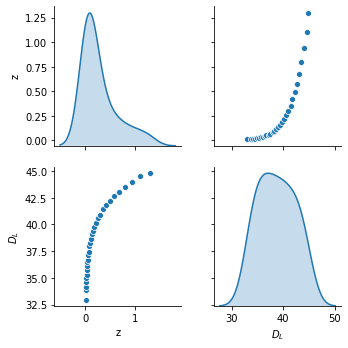

In [125]:
file2 = '/home/isidro/Documents/gitHub/misRepos/neuralCosmoReconstruction/data/jla_binned_distances_31nodes_v1.txt'
data = pd.read_csv(file2, names=['z', '$D_L$'], sep = " ", skiprows=3)
print(data.head(31))
sns.pairplot(data, diag_kind="kde")
plt.savefig("DistbinnedJLA.png")

In [126]:
shuffle = [x for x in range(len(data.values)) if x%2 ==1]
comp = [x for x in range(len(data.values)) if x%2 ==0]
shuffle.extend(comp)

data = data.values[shuffle]

In [127]:
z = data[:,0]
dl = data[:,1:]

In [128]:
# scalerz = StandardScaler()
# # scalerz = MinMaxScaler(feature_range=(-1,1))
# # fit scaler on data
# scalerz.fit(z.reshape(-1,1))
# # apply transform
# z = scalerz.transform(z.reshape(-1,1))

In [129]:
split = 0.8
ntrain = int(split * len(z))
indx = [ntrain]
z_train, z_test = np.split(z, indx)
dl_train, dl_test = np.split(dl, indx)

In [130]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0.,
                                   patience=200,
                                   restore_best_weights=True)]

In [131]:
def model(input_z):
    efirst = Dense(50, activation='relu', input_shape=(1,))(input_z)
    x = Dense(50, activation='relu')(efirst)
    x = Dense(50, activation='relu')(x)
    x = Dense(50, activation='relu')(x)
    x = Dense(50, activation='relu')(x)
    x = Dense(50, activation='relu')(x)
    elast = Dense(1, activation='linear')(x)
    return elast

batch_size = 2
epochs = 200
input_z = Input(shape = (1,))
neural_model = Model(input_z, model(input_z))
neural_model.compile(loss='mean_squared_error', optimizer = "adam")
neural_model.summary()

Model: "functional_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 1)]               0         
_________________________________________________________________
dense_36 (Dense)             (None, 50)                100       
_________________________________________________________________
dense_37 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_38 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_39 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_40 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_41 (Dense)             (None, 50)              

In [132]:
model_train = neural_model.fit(z_train, dl_train, batch_size=batch_size,
                                    epochs=epochs,verbose=1,
                                    validation_data=(z_test, dl_test),
                                    callbacks=callbacks)

Epoch 1/200
12/12 [==============================] - 0s 8ms/step - loss: 1430.1519 - val_loss: 1773.3925
Epoch 2/200
12/12 [==============================] - 0s 2ms/step - loss: 1412.1826 - val_loss: 1726.9005
Epoch 3/200
12/12 [==============================] - 0s 2ms/step - loss: 1350.4598 - val_loss: 1554.4713
Epoch 4/200
12/12 [==============================] - 0s 2ms/step - loss: 1152.5872 - val_loss: 971.1664
Epoch 5/200
12/12 [==============================] - 0s 2ms/step - loss: 548.0886 - val_loss: 115.4785
Epoch 6/200
12/12 [==============================] - 0s 2ms/step - loss: 134.9085 - val_loss: 602.9648
Epoch 7/200
12/12 [==============================] - 0s 2ms/step - loss: 61.5114 - val_loss: 103.0507
Epoch 8/200
12/12 [==============================] - 0s 2ms/step - loss: 60.7256 - val_loss: 122.2457
Epoch 9/200
12/12 [==============================] - 0s 2ms/step - loss: 55.4816 - val_loss: 225.1932
Epoch 10/200
12/12 [==============================] - 0s 2ms/step - l

12/12 [==============================] - 0s 2ms/step - loss: 2.2363 - val_loss: 3.4476
Epoch 83/200
12/12 [==============================] - 0s 2ms/step - loss: 2.2704 - val_loss: 3.4503
Epoch 84/200
12/12 [==============================] - 0s 2ms/step - loss: 2.4945 - val_loss: 3.3969
Epoch 85/200
12/12 [==============================] - 0s 2ms/step - loss: 3.2120 - val_loss: 2.9220
Epoch 86/200
12/12 [==============================] - 0s 2ms/step - loss: 3.1912 - val_loss: 2.8196
Epoch 87/200
12/12 [==============================] - 0s 2ms/step - loss: 2.4997 - val_loss: 3.4199
Epoch 88/200
12/12 [==============================] - 0s 2ms/step - loss: 2.2803 - val_loss: 2.8671
Epoch 89/200
12/12 [==============================] - 0s 2ms/step - loss: 2.1613 - val_loss: 3.1942
Epoch 90/200
12/12 [==============================] - 0s 2ms/step - loss: 1.9868 - val_loss: 2.9178
Epoch 91/200
12/12 [==============================] - 0s 2ms/step - loss: 2.2855 - val_loss: 4.0952
Epoch 92/200


12/12 [==============================] - 0s 2ms/step - loss: 1.2429 - val_loss: 1.7184
Epoch 164/200
12/12 [==============================] - 0s 2ms/step - loss: 1.8019 - val_loss: 1.4883
Epoch 165/200
12/12 [==============================] - 0s 2ms/step - loss: 2.8525 - val_loss: 1.5143
Epoch 166/200
12/12 [==============================] - 0s 2ms/step - loss: 2.6278 - val_loss: 2.2513
Epoch 167/200
12/12 [==============================] - 0s 2ms/step - loss: 2.5322 - val_loss: 0.6292
Epoch 168/200
12/12 [==============================] - 0s 2ms/step - loss: 2.0243 - val_loss: 3.1902
Epoch 169/200
12/12 [==============================] - 0s 2ms/step - loss: 1.1918 - val_loss: 2.9222
Epoch 170/200
12/12 [==============================] - 0s 2ms/step - loss: 2.1605 - val_loss: 1.2967
Epoch 171/200
12/12 [==============================] - 0s 2ms/step - loss: 1.6327 - val_loss: 1.2540
Epoch 172/200
12/12 [==============================] - 0s 2ms/step - loss: 1.2477 - val_loss: 0.9211
Epoc

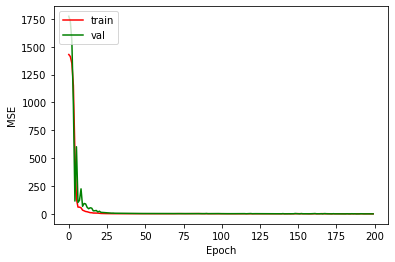

In [133]:
plt.plot(model_train.history['loss'], color='r', )
plt.plot(model_train.history['val_loss'], color='g')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("loss_dlbinnedJla.png", dpi=200)

In [134]:
unet = np.sqrt(np.min(model_train.history['val_loss']))
unet**2, np.min(model_train.history['loss'])

(0.2646055817604065, 0.9108514785766602)

In [135]:
pred = neural_model.predict(z_test)
pred

array([[38.763947],
       [40.28596 ],
       [41.06338 ],
       [41.80581 ],
       [42.83284 ],
       [44.253586],
       [46.58747 ]], dtype=float32)

In [136]:
ranz = np.random.uniform(0, np.max(z), size=31)
# ranzinv = scalerz.transform(ranz.reshape(-1,1))

pred_random = neural_model.predict(ranz)
pred_random

array([[37.65406 ],
       [44.800537],
       [34.95666 ],
       [43.40854 ],
       [38.670204],
       [41.43819 ],
       [44.741814],
       [43.261936],
       [36.052586],
       [37.60132 ],
       [38.520443],
       [44.019363],
       [42.570618],
       [44.960117],
       [43.73247 ],
       [43.20395 ],
       [44.26927 ],
       [38.158436],
       [41.99545 ],
       [36.724472],
       [42.06951 ],
       [43.005714],
       [42.974995],
       [41.798836],
       [38.121964],
       [43.038105],
       [44.05695 ],
       [36.885456],
       [44.625546],
       [45.00481 ],
       [43.90606 ]], dtype=float32)

In [137]:
# recover z
# z = scalerz.inverse_transform(z)

### Now we use randz (fake z) as inpute of the decoder neural netkork. But it is worth to make a mapping

$z_{original} \rightarrow encoded_{vals} \implies z_{original} \alpha =  encoded_{vals} \implies \alpha = \frac{encoded}{z_{original}}$

So, for fake z:

$encoded_{fake} = \alpha z_{fake}$



In [138]:
fake_encoded = np.zeros((1, 31))

In [139]:
print(np.shape(fake_encoded))
avg_encoded = np.mean(encoded_imgs, axis=0)
print(np.shape(avg_encoded))
print(np.shape(encoded_imgs))


(1, 31)
(31,)
(200, 31)


In [140]:
for i, avg in enumerate(avg_encoded):
    alpha = avg/z[i]
    fake_encoded[0, i] = alpha * ranz[i]

In [141]:
decoded_fake = decoder.predict(fake_encoded)
np.shape(decoded_fake)

(1, 961)

In [142]:
decoded_fake[0, :]

array([ 2.12385133e-02, -1.10068182e-02,  2.20606453e-03,  8.23846320e-04,
        7.49023049e-04,  7.54730951e-04,  5.50345052e-04,  9.80464276e-04,
        1.99755159e-04,  2.83567177e-04,  6.13675220e-04,  5.18654881e-04,
        1.21606456e-04,  1.76029280e-04,  8.12296523e-04,  1.42704463e-04,
        3.04019544e-04,  1.55802059e-04,  5.22634888e-04, -3.03077337e-04,
        7.83905387e-04,  3.35666817e-04, -4.47364291e-05,  6.41064253e-06,
        1.97774731e-04,  1.46298349e-04,  1.25503808e-04, -3.87819891e-04,
        5.94737125e-04,  9.98600808e-05, -1.73422042e-04, -1.13945855e-02,
        2.75065601e-02, -2.79447786e-03,  1.44241494e-03, -4.36794478e-04,
        5.56005281e-04,  1.02115574e-03, -7.15752132e-04,  3.05882655e-04,
        2.81884451e-04, -7.77348643e-04, -3.97031778e-04,  4.93607833e-04,
        8.18128872e-04,  6.84090774e-04,  8.75128899e-04,  9.45130654e-04,
       -4.12825088e-04,  1.09427725e-04,  4.05415194e-05,  1.00662000e-04,
        6.72778988e-04,  

3.8139115e-07

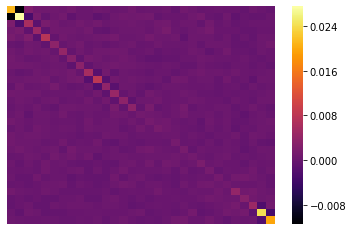

In [143]:
sns.heatmap(pd.DataFrame(decoded_fake[0, :].reshape(31,31)), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

clean_img = autoencoder.predict(decoded_fake[0, :].reshape(1,-1))
plt.savefig('fake_cov_jla.png', dpi=200)
np.min(np.abs(decoded_fake[0, :]))

1.6973354e-06

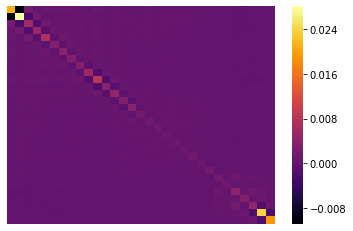

In [144]:
clean_img = autoencoder.predict(decoded_fake[0, :].reshape(1,-1))
sns.heatmap(pd.DataFrame(clean_img[0, :].reshape(31,31)), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)
plt.savefig('fake_cov_clean_jla.png', dpi=200)
np.min(np.abs(clean_img[0, :]))

In [145]:
np.savetxt("fake_binned_JLA_COVs.dat", decoded_fake[0, :].reshape(31,31), delimiter= " ", header="#fake COV")
np.savetxt("fake_binned_JLA_COV.dat", clean_img[0, :].reshape(31,31), delimiter= " ", header="#fake COV")

In [146]:
count = 0
new_cov =decoded_fake[0, :].reshape(31,31)

for i in range(len(new_cov)):
    for j in range(len(new_cov)):
        if np.iscomplex(new_cov[i,j]):
            print("COMPLEX")
        if new_cov[i,j] != new_cov[j,i]:
            print(i,j, end=' ')
            print(new_cov[i,j], new_cov[j,i]) 
            count+=1
            new_cov[j,i] = new_cov[i, j]

count

0 1 -0.011006818 -0.0113945855
0 2 0.0022060645 0.0019074354
0 3 0.0008238463 0.0010250671
0 4 0.00074902305 0.001503915
0 5 0.00075473095 -0.00011351879
0 6 0.00055034505 0.00071235007
0 7 0.0009804643 0.0010487116
0 8 0.00019975516 0.00084774697
0 9 0.00028356718 0.00029390716
0 10 0.0006136752 0.0005611515
0 11 0.0005186549 -0.00016488018
0 12 0.000121606456 0.0008093859
0 13 0.00017602928 0.00019655886
0 14 0.0008122965 -4.8724774e-05
0 15 0.00014270446 0.00023617662
0 16 0.00030401954 0.0009909784
0 17 0.00015580206 -8.9951034e-05
0 18 0.0005226349 0.00081347115
0 19 -0.00030307734 0.0008424153
0 20 0.0007839054 0.00046849123
0 21 0.00033566682 -2.3022876e-05
0 22 -4.473643e-05 0.0005829657
0 23 6.4106425e-06 0.00016737742
0 24 0.00019777473 0.0004544638
0 25 0.00014629835 -0.000101781334
0 26 0.00012550381 0.0009498534
0 27 -0.0003878199 -0.00026368105
0 28 0.0005947371 -0.0003183924
0 29 9.986008e-05 0.0002040232
0 30 -0.00017342204 0.00033681976
1 2 -0.0027944779 -0.0025135023


465

In [147]:
np.savetxt("fake_binned_JLA_COVsim.dat", new_cov, delimiter= " ", header="#fake COV")

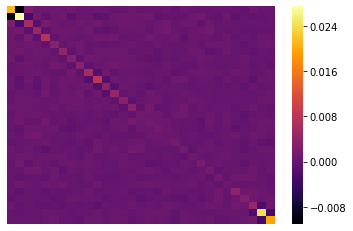

In [148]:
sns.heatmap(pd.DataFrame(new_cov), fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

In [149]:
fake_data = np.concatenate((ranz.reshape(-1,1), pred_random), axis=1)


np.savetxt("fake_binned_JLA.dat",  fake_data, delimiter= " ", header="#fake data\n# z\n# mu")
fake_data


array([[1.33652423e-01, 3.76540604e+01],
       [1.04000508e+00, 4.48005371e+01],
       [7.62129990e-03, 3.49566612e+01],
       [7.84859921e-01, 4.34085388e+01],
       [1.81129854e-01, 3.86702042e+01],
       [4.23698882e-01, 4.14381905e+01],
       [1.02924165e+00, 4.47418137e+01],
       [7.57986758e-01, 4.32619362e+01],
       [5.88262698e-02, 3.60525856e+01],
       [1.31187859e-01, 3.76013184e+01],
       [1.74132175e-01, 3.85204430e+01],
       [8.96821385e-01, 4.40193634e+01],
       [6.31270846e-01, 4.25706177e+01],
       [1.06925610e+00, 4.49601173e+01],
       [8.44235353e-01, 4.37324715e+01],
       [7.47359580e-01, 4.32039490e+01],
       [9.42627787e-01, 4.42692719e+01],
       [1.57218254e-01, 3.81584358e+01],
       [5.25843947e-01, 4.19954491e+01],
       [9.02187935e-02, 3.67244720e+01],
       [5.39419283e-01, 4.20695114e+01],
       [7.11022652e-01, 4.30057144e+01],
       [7.05392549e-01, 4.29749947e+01],
       [4.89803243e-01, 4.17988358e+01],
       [1.555141

In [150]:
errors = np.sqrt(np.abs(np.diagonal(syscov)))
fakeerrors = np.sqrt(np.abs(np.diagonal(clean_img.reshape(31,31))))

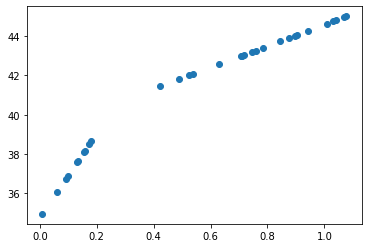

In [151]:
plt.scatter(ranz, pred_random)

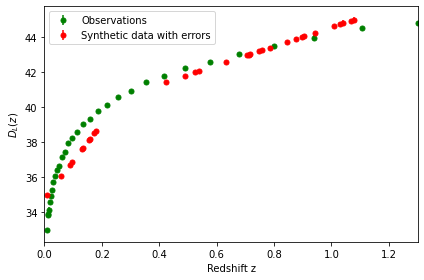

In [152]:
plt.errorbar(z, dl, yerr=errors, fmt='g.', markersize=10, label='Observations')
plt.errorbar(ranz, pred_random, 
             yerr=fakeerrors, fmt='r.', markersize=10., label='Synthetic data with errors')

# plt.plot(z, Hlcdm(z), label='$\Lambda CDM$ $H_0 = 73.24$', c='k')
# plt.plot(z, Hlcdm(z, H0=67.4), label='$\Lambda CDM$ $H_0 = 67.4$', c='b')
plt.xlabel("Redshift z")
plt.ylabel("$D_L(z)$")
plt.xlim(0, np.max(z))
plt.tight_layout()
plt.legend()
plt.savefig('fake_vs_binned_jla.png', dpi=200)

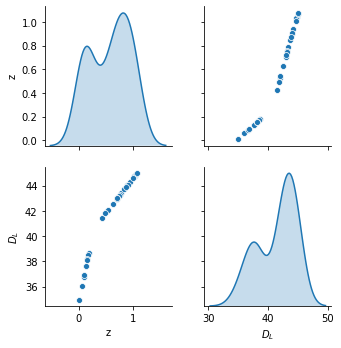

In [153]:
fake_datadf = pd.DataFrame(fake_data, columns=['z', '$D_L$'])
sns.pairplot(fake_datadf, diag_kind="kde")
plt.savefig('fake_binned_jla.png')